In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import LatentDirichletAllocation

import glob, os



In [53]:
file_list = glob.glob(os.getcwd() + '/dump/*.csv') # Recuperar la lista con todos los .csv en la carpeta dump

append_csv = [] # Arreglo de pd.Dataframes
for f in file_list:
    append_csv.append(pd.read_csv(f, index_col = None,
                     header = 0).drop(columns = 'Unnamed: 0'))
df_lyrics = pd.concat(append_csv) # Concatenamos todos los datafrrames en uno solo
df_lyrics.columns = ['Artist', 'Genre', 'Song', 'Lyrics'] # Renombramos las columnas del nuevo dataframe

In [54]:
df_lyrics['Genre'].value_counts()

rock      4140
hiphop    2535
metal     1582
pop       1232
Name: Genre, dtype: int64

In [58]:
counter = CountVectorizer(stop_words='english', max_df=.1, max_features=5000)
transformed_feats = counter.fit_transform(df_lyrics['Lyrics'])

In [ ]:
search_params = {'n_components': [5, 10, 15], 'learning_decay': [0.7, 0.5]}
# Por defecto GridSearchCV implementa 3 validaciones. Hay un total de 18 modelos por estimar.
cv_lda_model = GridSearchCV(LatentDirichletAllocation(learning_method='online'),
                            param_grid=search_params, n_jobs=-1,
                            cv = 5).fit(transformed_feats)

In [63]:
best_lda = cv_lda_model.best_estimator_
print("Best hyperparams: {}".format(cv_lda_model.best_params_))
print("Best Loglikelihood: {}".format(cv_lda_model.best_score_))
print("Best Preplexity: {}".format(best_lda.perplexity(transformed_feats)))

Best hyperparams: {'learning_decay': 0.7, 'n_components': 5}
Best Loglikelihood: -1321009.4557017342
Best Preplexity: 2230.5604930017403


In [67]:
from joblib import dump, load

#dump(cv_lda_model.best_estimator_, 'Latent_dirichlet_alloc.joblib') 
best_lda = load('Latent_dirichlet_alloc.joblib')

## Ejercicio 4: Identificación de Tópicos

In [75]:
best_lda.components_.shape

(5, 5000)

In [76]:
# mediante .components_ podemos extraer una matriz que entrega las distribución de palabras por cada tópico.
for topic_id, topic_name in enumerate(best_lda.components_):
    # para cada tópico
    print("tópico: {}".format(topic_id + 1))
    # mediante argsort logramos ordenar los elementos por magnitud
    # para los elementos más relevantes ordenados por argsort, buscamos su correlativo
    # en la matriz dispersa y devolvemos el nombre.
    # finalmente concatenamos las palabras
    print(" ".join([counter.get_feature_names()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))

tópico: 1
rock roll uh beat mos def everybody yes hands whoa party ready jump ha mon
tópico: 2
niggas niggaz ma fuckin gon rap bitches game da uh dre bout wit verse eminem
tópico: 3
didn talk friends everybody wrong dance mama maybe work somebody going crazy took friend went
tópico: 4
ooh ah la tonight ba na believe moment boom body bring yes future babe save
tópico: 5
sun pain fall hell sky dream forever coming lost rain kill war cold free dark


In [119]:
best_lda.components_

(5, 5000)

In [122]:
for topic_id, topic_name in enumerate(best_lda.components_):
    print("tópico: {}".format(topic_id + 1))
    print(" ".join([counter.get_feature_names()[i] for 
                    i in topic_name.argsort()[:-15 - 1: -1]]))

tópico: 1
rock roll uh beat mos def everybody yes hands whoa party ready jump ha mon
tópico: 2
niggas niggaz ma fuckin gon rap bitches game da uh dre bout wit verse eminem
tópico: 3
didn talk friends everybody wrong dance mama maybe work somebody going crazy took friend went
tópico: 4
ooh ah la tonight ba na believe moment boom body bring yes future babe save
tópico: 5
sun pain fall hell sky dream forever coming lost rain kill war cold free dark


## Ejercicio 5: Identificación de probabilidades

In [130]:
fit_best_lda.shape

(9489, 5)

In [128]:
# generamos una transformación de los datos a distribución de tópico por palabra en el documento
fit_best_lda = best_lda.transform(transformed_feats)
# esta transformación la podemos coercionar a un dataframe de la siguiente manera

topics_for_each_doc = pd.DataFrame(
    # pasamos esta matriz y la redondeamos en 3 decimales
    np.round(fit_best_lda, 3),
    # agregamos un índice
    index=df_lyrics.index
)

#agregamos identificadores de columna
topics_for_each_doc.columns = list(
                    map(lambda x: "T: {}".format(x),
                    range(1, best_lda.n_components + 1)))

topics_for_each_doc.head()



,T: 1,T: 2,T: 3,T: 4,T: 5
0,0.497,0.094,0.212,0.001,0.196
1,0.240,0.131,0.512,0.002,0.114
2,0.749,0.127,0.026,0.001,0.096
3,0.889,0.049,0.001,0.059,0.001
4,0.538,0.003,0.234,0.003,0.221


In [135]:
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([df_lyrics, topics_for_each_doc], axis=1)
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values, axis=1) + 1

In [138]:
concatenated_df.sample(10)

,Artist,Genre,Song,Lyrics,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
65,Pink Floyd,rock,Pigs On The Wing (1),If you didn't care what happened to me \n And ...,0.015,0.016,0.487,0.016,0.465,3
108,Weezer,rock,Thank God For Girls,"Unfortunately, we are not licensed to display ...",0.018,0.018,0.018,0.927,0.018,4
22,SIA,pop,Insidiously,Mind you mind me \n You thought you could clim...,0.006,0.006,0.624,0.122,0.243,3
6,The Smashing Pumpkins,rock,Snail,All your seven dreams \n Look closer than you ...,0.004,0.004,0.155,0.096,0.740,5
142,Anthrax,metal,This Battle Chose Us,You give them hell \n Straight to the chin \n ...,0.002,0.002,0.002,0.026,0.968,5
205,Eminem,hiphop,Desperation,Girl you gimme writers block \n I'm at a loss ...,0.055,0.327,0.358,0.002,0.259,3
308,Bruce Springsteen,rock,Breakaway,Sonny abandoned his car last night \n Had a me...,0.003,0.064,0.372,0.003,0.558,5
9,Nicki Minaj,pop,Nicki Minaj Speaks#2,"Holiday, Holiday, slow that shit DOWN! \n C'mo...",0.483,0.076,0.433,0.003,0.003,1
96,Mobb Deep,hiphop,Can't Fuck With Us (Freestyle),{*Opening gunshot courtesy DJ Whoo Kid*} \n (H...,0.052,0.826,0.002,0.002,0.119,2
17,Pink Floyd,rock,Let There Be More Light,Far far far far away way \n People heard him s...,0.005,0.051,0.005,0.087,0.852,5


Matriz de correlaciones entre los tópicos inferidos

In [148]:
fit_best_lda = best_lda.transform(transformed_feats)

topics = list(map(lambda x: "topic {}".format(x), range(1, best_lda.n_components + 1)))

docs_topics = pd.DataFrame(np.round(fit_best_lda, 3), columns=topics, index=df_lyrics.index)

concatenate_pr_songs = pd.concat([df_lyrics, docs_topics], axis=1)

concatenate_pr_songs['highest_topic'] = np.argmax(docs_topics.values, axis=1)+1

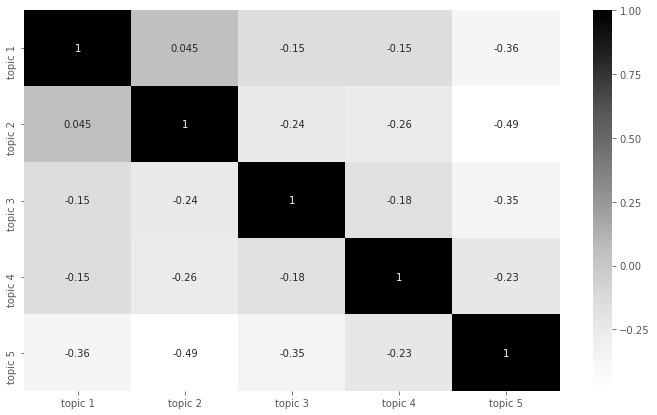

In [147]:
plt.rcParams['figure.figsize'] = (12,7)
sn.heatmap(concatenate_pr_songs.loc[:, 'topic 1':'topic 5'].corr(), annot=True, cmap='Greys');

In [141]:
df_lyrics['Artist'].value_counts()

Eminem                      493
Bruce Springsteen           467
Bob Dylan                   447
Britney Spears              323
Nicki Minaj                 282
Michael Jackson             279
Kanye West                  273
The Beatles                 265
Ghostface Killah            255
The Smashing Pumpkins       254
Weezer                      251
Mobb Deep                   231
Red Hot Chili Peppers       226
Kiss                        219
The Doors                   214
Public Enemy                198
Megadeth                    190
Queen                       188
Iron Maiden                 185
Raekwon                     184
De La Soul                  174
Cannibal Corpse             171
Anthrax                     170
Rush                        167
Metallica                   155
Modest Mouse                154
Radiohead                   151
Slayer                      147
The Clash                   145
Pink Floyd                  135
                           ... 
Kendrick

In [149]:
def fetch_mixture(df, artist):
    return df[df['Artist'] == artist].loc[:, 'topic 1':'topic 5']

mos_def = fetch_mixture(concatenate_pr_songs, 'Lorde')
mos_def.columns = ['hardcore-rap', 'rock', 'pop', 'metal', 'bling-era']
mos_def.apply(np.mean, axis=0).sort_values()

metal           0.071852
rock            0.078111
hardcore-rap    0.086741
bling-era       0.353481
pop             0.409815
dtype: float64

Distribución de probabilidades para un artista:

/Users/ignacio/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


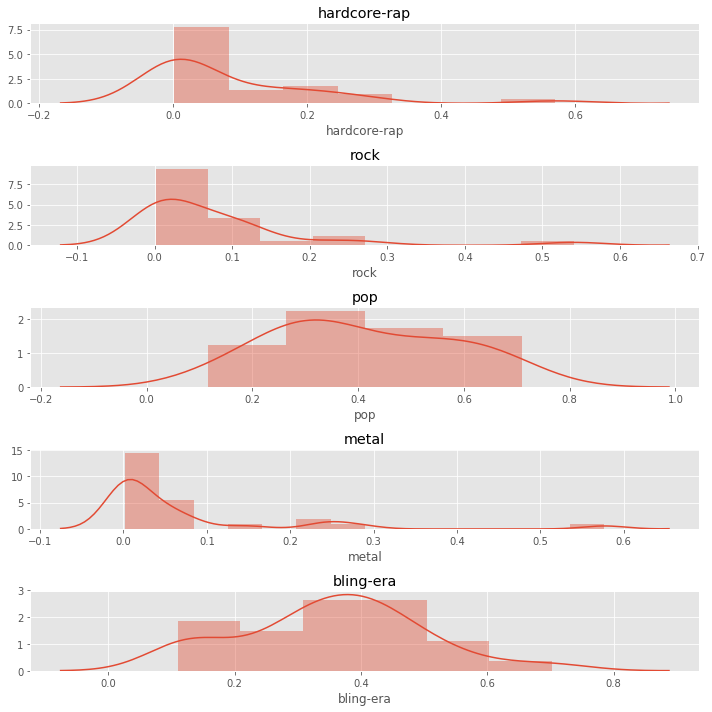

In [152]:
plt.figure(figsize=(10, 10))
for index, (colname, serie) in enumerate(mos_def.iteritems()):
    plt.subplot(5, 1, index + 1)
    sn.distplot(serie)
    plt.title(colname)
    plt.tight_layout()